$1.\text{클러스터링이란?}$<br>
클러스터링(clustering)은 단일 그룹 내의 모든 항목이 서로 최대한 비슷하면서도<br>
다른 그룹의 항목과 최대한 유사하도록 개체를 그룹화하는 것을 목표로 하는 비지도 기계 학습 알고리즘이다.<br>
처음 들어보면 이게 무슨소리지? 싶은데 정말 간단하게 예를 들어보자면<br>
![title](../photo/Kmens.png)<br>
이런식으로 분류되지 않은 데이터세트를 분류된 데이터세트로 분리하는 작업이라 할 수 있다.<br>
Kmeans, GMM, Spectral clustering 이 대표적인 클러스터링 방법이고 이중에서 kmeans 클러스터링을 구현 해 보는게 목표다.<br>

핵심적으로 알아야 하는 지식은 WCSS,M_step,E_Sstep로 
![title](../photo/KNN_COST.png)<br>
우선 wcss(cost function)에 대해 간단히 살펴보자 

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys
from pathlib import Path
sys.path.insert(0, str(Path(r'D:\OneDrive\Documents\SJTU 과제\기계학습(머신러닝)\Machine_Learning\MyPackage\CHAE_ML.py').resolve().parent.parent))
from MyPackage import CHAE_ML
df = pd.read_csv('../iris.data')
df.reset_index(drop=True, inplace=True)
#df.info()
m, n = df.shape
print('Number of training examples m = ', m)
print('Number of features n = ', n - 1)
df.head()

Number of training examples m =  150
Number of features n =  4


,sepal.lenth,sepal.width,petal.lenth,petal.width,type
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [2]:
df['type'].value_counts()

0    50
1    50
2    50
Name: type, dtype: int64

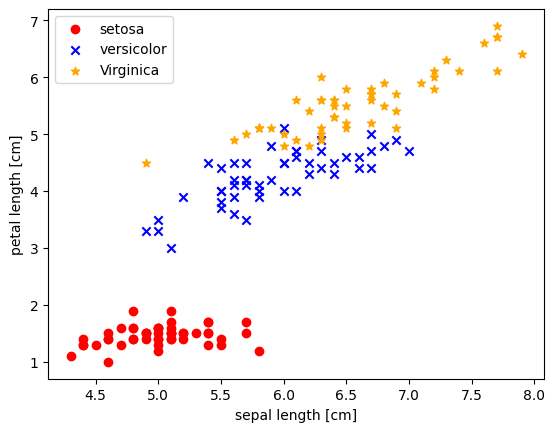

In [3]:
y = df.iloc[0:150, 4].values
#y = np.where(y == '0', -1, 1)
# 꽃받침 길이와 꽃잎 길이를 추출합니다
x = df.iloc[:, [0, 2]].values
#print(x)
#print(y)
# 산점도를 그립니다, setosa-음성, versicolor-양성
plt.scatter(x[:50, 0], x[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(x[50:100, 0], x[50:100, 1],
            color='blue', marker='x', label='versicolor')
plt.scatter(x[100:, 0], x[100:, 1],
            color='orange', marker='*', label='Virginica')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/02_06.png', dpi=300)
plt.show()

In [5]:
"""K-Means++ class made for multiple parameters. Returns k initial seeds to be used in Equal_Cluster_K_Means"""
import numpy as np
import random
import math

class K_Means_Plus_Plus:

    """Input is a 2D list of n-dimensional points"""
    def __init__(self, points_list, k):
        self.centroid_count = 0
        self.point_count = len(points_list)
        self.cluster_count = k
        self.points_list = list(points_list)
        self.initialize_random_centroid()
        self.initialize_other_centroids()

    """Picks a random point to serve as the first centroid"""
    def initialize_random_centroid(self):
        self.centroid_list = []
        index = random.randint(0, len(self.points_list)-1)

        self.centroid_list.append(self.remove_point(index))
        self.centroid_count = 1

    """Removes point associated with given index so it cannot be picked as a future centroid.
    Returns list containing coordinates of newly removed centroid"""
    def remove_point(self, index):
        new_centroid = self.points_list[index]
        del self.points_list[index]

        return new_centroid

    """Finds the other k-1 centroids from the remaining lists of points"""
    def initialize_other_centroids(self):
        while not self.is_finished():
            distances = self.find_smallest_distances()
            chosen_index = self.choose_weighted(distances)
            self.centroid_list.append(self.remove_point(chosen_index))
            self.centroid_count += 1


    """Calculates distance from each point to its nearest cluster center. Then chooses new
    center based on the weighted probability of these distances"""
    def find_smallest_distances(self):
        distance_list = []

        for point in self.points_list:
            distance_list.append(self.find_nearest_centroid(point))

        return distance_list

    """Finds centroid nearest to the given point, and returns its distance"""
    def find_nearest_centroid(self, point):
        min_distance = math.inf

        for values in self.centroid_list:
            distance = self.euclidean_distance(values, point)
            if distance < min_distance:
                min_distance = distance

        return min_distance

    """Chooses an index based on weighted probability"""
    def choose_weighted(self, distance_list):
        distance_list = [x**2 for x in distance_list]
        weighted_list = self.weight_values(distance_list)
        indices = [i for i in range(len(distance_list))]
        return np.random.choice(indices, p = weighted_list)

    """Weights values from [0,1]"""
    def weight_values(self, list):
        sum = np.sum(list)
        return [x/sum for x in list]

    """computes N-d euclidean distance between two points represented as lists:
     (x1, x2, ..., xn) and (y1, y2, ..., yn)"""
    def euclidean_distance(self, point1, point2):
        point1 = np.asarray(point1)
        point2 = np.asarray(point2)

        return np.linalg.norm(point2-point1)

    """Checks to see if final condition has been satisfied (when K centroids have been created)"""
    def is_finished(self):
        outcome = False
        if self.centroid_count == self.cluster_count:
            outcome = True

        return outcome

    """Returns final centroid values"""
    def final_centroids(self):
        return self.centroid_list

In [6]:
labels = np.zeros(len(samples))
sepal_length_width = np.array(list(zip(x, y)))
# 각 데이터를 순회하면서 centroids와의 거리를 측정합니다
for i in range(len(samples)):
  distances = np.zeros(k)	# 초기 거리는 모두 0으로 초기화 해줍니다
  for j in range(k):
    distances[j] = distance(sepal_length_width[i], centroids[j])
  cluster = np.argmin(distances)	# np.argmin은 가장 작은 값의 index를 반환합니다
  labels[i] = cluster

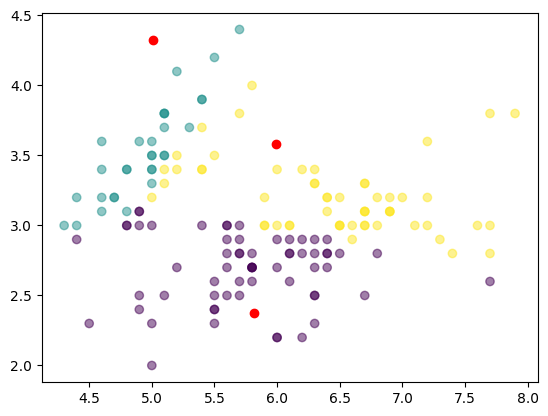

In [7]:
plt.scatter(x, y, c=labels, alpha=0.5)
plt.scatter(centroids_x, centroids_y, c='red')	# centroid는 빨간색으로 나타냅니다
plt.show()

In [8]:
from copy import deepcopy
centroids_old = deepcopy(centroids)

In [9]:
for i in range(k):
  # 각 그룹에 속한 데이터들만 골라 points에 저장합니다
  points = [ sepal_length_width[j] for j in range(len(sepal_length_width)) if labels[j] == i ]
  # points의 각 feature, 즉 각 좌표의 평균 지점을 centroid로 지정합니다
  centroids[i] = np.mean(points, axis=0)

In [17]:
centroids_old = np.zeros(np.array(centroids).shape)	# 제일 처음 centroids_old는 0으로 초기화 해줍니다
labels = np.zeros(len(samples))
error = np.zeros(k)
# error 도 초기화 해줍니다
for i in range(k):
  error[i] = distance(centroids_old[i], centroids[i]) #centroid old랑 centrod i를 업데이트 
# STEP 4: error가 0에 수렴할 때 까지 2 ~ 3 단계를 반복합니다
while(error.all() != 0):
  # STEP 2: 가까운 centroids에 데이터를 할당합니다
  for i in range(len(samples)):
    distances = np.zeros(k)	# 초기 거리는 모두 0으로 초기화 해줍니다
    for j in range(k):
      distances[j] = distance(sepal_length_width[i], centroids[j])
    cluster = np.argmin(distances)	# np.argmin은 가장 작은 값의 index를 반환합니다
    labels[i] = cluster
  # Step 3: centroids를 업데이트 시켜줍니다
  centroids_old = deepcopy(centroids)
  for i in range(k):
    # 각 그룹에 속한 데이터들만 골라 points에 저장합니다
    points = [ sepal_length_width[j] for j in range(len(sepal_length_width)) if labels[j] == i ]
    # points의 각 feature, 즉 각 좌표의 평균 지점을 centroid로 지정합니다
    centroids[i] = np.mean(points, axis=0)
  # 새롭게 centroids를 업데이트 했으니 error를 다시 계산합니다
  for i in range(k):
    error[i] = distance(centroids_old[i], centroids[i])
    print(error)

[0.03545979 6.08876619 7.44984172]
[0.03545979 0.02523047 7.44984172]
[0.03545979 0.02523047 0.01271322]
[0.01033248 0.02523047 0.01271322]
[0.01033248 0.         0.01271322]
[0.01033248 0.         0.01211672]


[[5.72884615 2.68269231]
 [5.01632653 3.45102041]
 [6.79183673 3.06122449]]


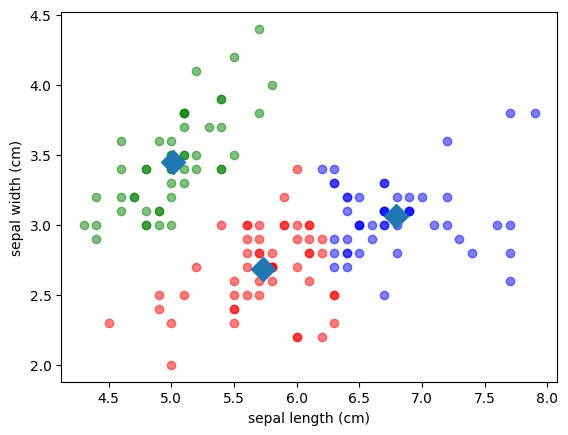

In [16]:
colors = ['r', 'g', 'b']
for i in range(k):
    points = np.array([sepal_length_width[j] for j in range(len(sepal_length_width)) if labels[j] == i])
    plt.scatter(points[:, 0], points[:, 1], c=colors[i], alpha=0.5)
print(np.array(centroids))
centroids = np.array(centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='D', s=150)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.show()